In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import h5py
import datetime
import henon_map_cpp as hm
import scipy.integrate as integrate
import lmfit
from tqdm.notebook import tqdm
from numba import njit, cfunc, carray
from numba.types import intc, CPointer, float64

In [2]:
def do_integrate(func, a, b):
    return integrate.quad(func, a, b)[0]

In [3]:
@njit
def nek_d(kappa, I_ast, I):
    return np.exp(-2 * (I_ast/I) ** (1 / (2*kappa)))


@njit
def inverse_nek_d(kappa, I_ast, I):
    return 1 / np.exp(-2 * (I_ast/I) ** (1 / (2*kappa)))


@njit
def nu(kappa, I_ast, I):
    return (1 / (2*kappa)) * (1 / I) * (I_ast / I)**(1 / (2*kappa)) * np.exp(-(I_ast / I)**(1 / (2*kappa)))


def I_to_x(I, I_a, func_nek):
    # if I is a scalar
    if np.isscalar(I):
        return -do_integrate(func_nek, I, I_a)
    # if I is an array
    else:
        return np.array([-do_integrate(func_nek, i, I_a) for i in I])
    

def ja(I, I_a, t, kappa, I_ast):
    func_nek = cfunc("float64(float64)")(lambda x: inverse_nek_d(kappa, I_ast, x))
    # if t is a scalar
    if np.isscalar(t):
        return np.abs(I_to_x(I, I_a, func_nek)) / (t * np.sqrt(2*np.pi*t)) * np.exp(-(I_to_x(I, I_a, func_nek) + (nu(kappa, I_ast, I) * t))**2 / (2*t))
    # if t is an array
    result = np.empty_like(t)
    for i in range(len(t)):
        result[i] = np.abs(I_to_x(I, I_a, func_nek)) / (t[i] * np.sqrt(2*np.pi*t[i])) * np.exp(-(I_to_x(I, I_a, func_nek) + (nu(kappa, I_ast, I) * t[i]))**2 / (2*t[i]))
    return result


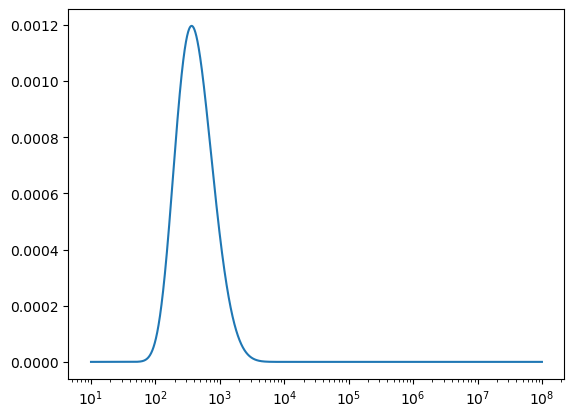

In [4]:
t_list = np.logspace(1, 8, 50000)
kappa = 0.7
Iast = 10.0
from_I = 5.0
to_I = 7.0

current = ja(from_I, to_I, t_list, kappa, Iast)

plt.plot(t_list, current)
plt.xscale('log')

In [81]:
OMEGA_X = 0.168 # 0.168
OMEGA_Y = 0.201 # 0.201
EPSILON = 32.0
MU = 0.00
R_MAX = 0.75

In [23]:
OMEGA_X = 0.28 # 0.168
OMEGA_Y = 0.31 # 0.201
EPSILON = 32.0
MU = 0.00
R_MAX = 0.5

In [24]:
angles = np.linspace(0, np.pi / 2, 100)
radiuses = np.linspace(0, R_MAX, 100 + 1)[1:]

rr, aa = np.meshgrid(radiuses, angles)

xx = rr * np.cos(aa)
x = xx.flatten()
px = np.zeros_like(x)
yy = rr * np.sin(aa)
y = yy.flatten()
py = np.zeros_like(y)

particles = hm.particles(x, px, y, py, force_CPU=True)

In [25]:
particles.get_radius_std()

array(0.14433035)

In [26]:
# start chronometer
start = datetime.datetime.now()

tracker = hm.henon_tracker(int(1e5), OMEGA_X, OMEGA_Y, "sps", epsilon=EPSILON, force_CPU=True)
tracker.track(particles, int(1e5), mu=MU, barrier=1.0)
steps = particles.get_steps()

# end chronometer
end = datetime.datetime.now()

# print elapsed time
print("Elapsed time: {}".format(end - start))

Elapsed time: 0:00:02.836637


/tmp/ipykernel_34363/1387140760.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')
/tmp/ipykernel_34363/1387140760.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Survival time')
/tmp/ipykernel_34363/1387140760.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])


[Text(1, 0.0, '$10^0$'),
 Text(1, 1.0, '$10^1$'),
 Text(1, 2.0, '$10^2$'),
 Text(1, 3.0, '$10^3$'),
 Text(1, 4.0, '$10^4$'),
 Text(1, 5.0, '$10^5$')]

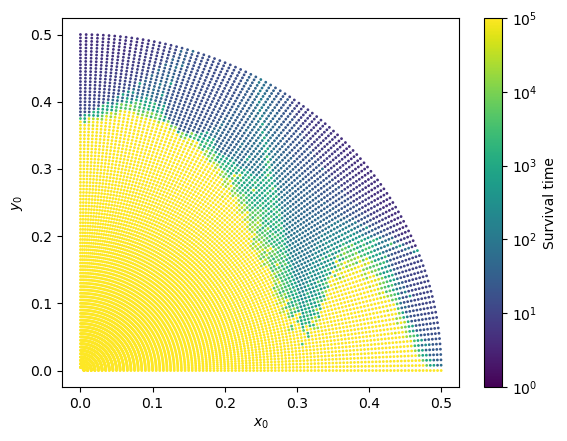

In [27]:
steps = particles.get_steps()
s = steps.flatten()
cmap = matplotlib.cm.get_cmap('viridis')
s_c = cmap(np.log10(s) / np.log10(int(1e5)))

plt.scatter(x, y, c=s_c, s=1)
# plt.scatter(np.linspace(0.1, 0.5, 41),np.linspace(0.1, 0.5, 41), c='r', s=5, marker="x")

plt.xlabel('$x_0$')
plt.ylabel('$y_0$')

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=5))
sm._A = []
cbar = plt.colorbar(sm, label='Survival time')
cbar.ax.set_yticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])

In [88]:
R_MIN = 0.1
R_MAX = 0.5
R_SAMPLES = 51
ANGLE_SAMPLES = 31

I_SAMPLES = 1000
STD_R = 0.001
STD_ANGLE = 0.001

TURNS = int(1e5)

r_list = np.linspace(R_MIN, R_MAX, R_SAMPLES)
a_list = np.linspace(0, 0.5*np.pi, ANGLE_SAMPLES)

In [8]:
I_std = []
angle_x_std = []
angle_y_std = []
steps = []
angle_val = []
radius_val = []

tracker = hm.henon_tracker(TURNS, OMEGA_X, OMEGA_Y, "sps", epsilon=EPSILON, force_CPU=False)

for i, r in enumerate(tqdm(r_list)):
    for q, a in enumerate(tqdm(a_list, leave=False)):
        spread_r = np.random.normal(0, STD_R, I_SAMPLES)
        spread_angles_x = np.random.normal(0, STD_ANGLE, I_SAMPLES)
        spread_angles_y = np.random.normal(0, STD_ANGLE, I_SAMPLES)

        x = (r + spread_r) * np.cos(a) * np.cos(spread_angles_x)
        px = (r + spread_r) * np.cos(a) * np.sin(spread_angles_x)
        y = (r + spread_r) * np.sin(a) * np.cos(spread_angles_y)
        py = (r + spread_r) * np.sin(a) * np.sin(spread_angles_y)

        x = x.flatten()
        px = px.flatten()
        y = y.flatten()
        py = py.flatten()

        particles = hm.particles(x, px, y, py, force_CPU=False)

        I_std_local = []
        angle_x_std_local = []
        angle_y_std_local = []
        time_samples = []

        I_std_local.append(particles.get_action_std())
        angle_x_std_local.append(particles.get_angle_x_std())
        angle_y_std_local.append(particles.get_angle_y_std())
        time_samples.append(0)

        for j in range(1, TURNS + 1):
            tracker.track(particles, 1, mu=MU, barrier=1.0)

            if j % 100 == 0:
                I_std_local.append(particles.get_action_std())
                angle_x_std_local.append(particles.get_angle_x_std())
                angle_y_std_local.append(particles.get_angle_y_std())
                time_samples.append(j)

        steps.append(particles.get_steps())
        I_std.append(I_std_local)
        angle_x_std.append(angle_x_std_local)
        angle_y_std.append(angle_y_std_local)
        angle_val.append(a)
        radius_val.append(r)

I_std = np.array(I_std)
angle_x_std = np.array(angle_x_std)
angle_y_std = np.array(angle_y_std)
steps = np.array(steps)
time_samples = np.array(time_samples)
angle_val = np.array(angle_val)
radius_val = np.array(radius_val)

creating gpu tracker


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [89]:
R_MIN = 0.1
R_MAX = 0.5
R_SAMPLES = 100

I_SAMPLES = 10000
STD_R = 0.001
STD_ANGLE = 0.001

TURNS = int(1e5)

r_list = np.linspace(R_MIN, R_MAX, R_SAMPLES)

In [90]:
I_std = []
angle_x_std = []
angle_y_std = []
steps = []
angle_val = []
radius_val = []

tracker = hm.henon_tracker(TURNS, OMEGA_X, OMEGA_Y, "sps", epsilon=EPSILON, force_CPU=False)

for i, r in enumerate(tqdm(r_list)):
    spread_r = np.random.normal(0, STD_R, I_SAMPLES)
    spread_angles_x = np.random.normal(0, STD_ANGLE, I_SAMPLES)
    spread_angles_y = np.random.normal(0, STD_ANGLE, I_SAMPLES)

    x = (r + spread_r) * np.cos(0.25 * np.pi) * np.cos(spread_angles_x)
    px = (r + spread_r) * np.cos(0.25 * np.pi) * np.sin(spread_angles_x)
    y = (r + spread_r) * np.sin(0.25 * np.pi) * np.cos(spread_angles_y)
    py = (r + spread_r) * np.sin(0.25 * np.pi) * np.sin(spread_angles_y)

    x = x.flatten()
    px = px.flatten()
    y = y.flatten()
    py = py.flatten()

    particles = hm.particles(x, px, y, py, force_CPU=False)

    I_std_local = []
    angle_x_std_local = []
    angle_y_std_local = []
    time_samples = []

    I_std_local.append(particles.get_action_std())
    angle_x_std_local.append(particles.get_angle_x_std())
    angle_y_std_local.append(particles.get_angle_y_std())
    time_samples.append(0)

    for j in range(1, TURNS + 1):
        tracker.track(particles, 1, mu=MU, barrier=1.0)

        if j % 100 == 0:
            I_std_local.append(particles.get_action_std())
            angle_x_std_local.append(particles.get_angle_x_std())
            angle_y_std_local.append(particles.get_angle_y_std())
            time_samples.append(j)

    steps.append(particles.get_steps())
    I_std.append(I_std_local)
    angle_x_std.append(angle_x_std_local)
    angle_y_std.append(angle_y_std_local)
    angle_val.append(0.25 * np.pi)
    radius_val.append(r)

I_std = np.array(I_std)
angle_x_std = np.array(angle_x_std)
angle_y_std = np.array(angle_y_std)
steps = np.array(steps)
time_samples = np.array(time_samples)
angle_val = np.array(angle_val)
radius_val = np.array(radius_val)

creating gpu tracker


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
np.count_nonzero(np.isnan(particles.get_action()))

9518

In [110]:
np.sqrt(x**2 + px**2 + y**2 + py**2)

array([0.49906255, 0.50067351, 0.49989843, ..., 0.49944378, 0.49931023,
       0.49940898])

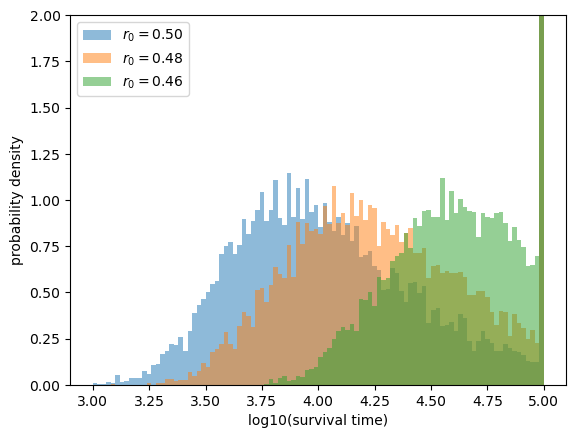

In [103]:
plt.hist(np.log10(steps[-1]), bins=100, density=True, label=f"$r_0={r_list[-1]:.2f}$", range=(3,5), alpha=0.5)
plt.hist(np.log10(steps[-5]), bins=100, density=True, label=f"$r_0={r_list[-5]:.2f}$", range=(3,5), alpha=0.5)
plt.hist(np.log10(steps[-10]), bins=100, density=True, label=f"$r_0={r_list[-10]:.2f}$", range=(3,5), alpha=0.5)

plt.xlabel("log10(survival time)")
plt.ylabel("probability density")
plt.ylim(0, 2)

plt.legend()

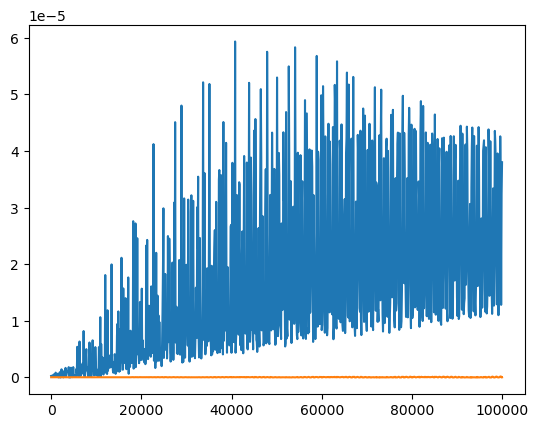

In [24]:
# plt.plot(I_std[-1]**2)
# plt.plot(time_samples, I_std[-1]**2)
plt.plot(time_samples, I_std[40]**2)
plt.plot()
plt.plot(time_samples, I_std[0]**2)

# plt.yscale("log")
# plt.xscale("log")

In [25]:
def linear_resid(params, x, data=None):
    a = params['a'].value
    b = params['b'].value
    model = a * x + b
    if data is None:
        return model
    return (model - data)

In [ ]:
I_std[0]

In [74]:
out_list = []
t_survival = []
actual_samples = []

for i, vy in enumerate(I_std):
    params = lmfit.Parameters()
    params.add('a', value=1.0)
    params.add('b', value=vy[0]**2)

    vx = time_samples.copy()
    mask = np.logical_and(vx > 5000, vx < np.min([1e5, np.min(steps[i])]))
    if np.count_nonzero(mask) < 10:
        mask = vx < np.min([1e5, np.min(steps[i])])
    vx = vx[mask]
    vy = vy[mask]

    actual_samples.append(vx)

    result = lmfit.minimize(linear_resid, params, args=(vx, vy**2))
    out_list.append(result)
    t_survival.append(np.min(steps[i]))

t_survival = np.array(t_survival)

In [75]:
a_list = np.array([o.params["a"].value for o in out_list])
red_chi = np.array([o.redchi for o in out_list])

Text(0, 0.5, 'Diffusion coefficient reconstructed')

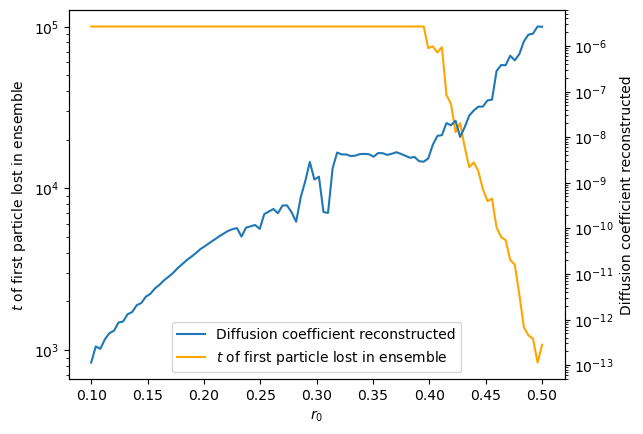

In [76]:
plt.plot([], [], label="Diffusion coefficient reconstructed")
plt.plot(r_list, t_survival, color='orange', label="$t$ of first particle lost in ensemble")
plt.yscale("log")
plt.ylabel("$t$ of first particle lost in ensemble")
plt.xlabel("$r_0$")
plt.legend(loc="lower center")
plt.twinx()
plt.plot(r_list, a_list)
plt.yscale("log")

plt.ylabel("Diffusion coefficient reconstructed")

# plt.plot(r_list, red_chi, color='orange')

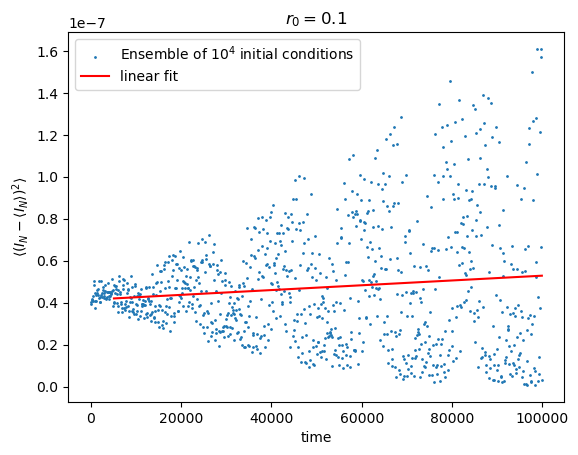

In [77]:
idx = 0

vx = time_samples.copy()
vy = I_std[idx, :]**2
# mask = np.logical_and(vx > 2500, vx < np.min([2e4, np.min(steps[idx])]))
# if np.count_nonzero(mask) < 10:
mask = vx < np.min(steps[idx])
vx = vx[mask]
vy = vy[mask]

plt.scatter(vx, vy, label='Ensemble of $10^4$ initial conditions', s=1)
plt.plot(actual_samples[idx], linear_resid(out_list[idx].params, actual_samples[idx]), label='linear fit', color='red')
plt.xlabel('time')
plt.ylabel('$\\langle(I_N - \\langle I_N\\rangle)^2\\rangle$')
plt.title(f"$r_0 = {r_list[idx]}$")
plt.legend()

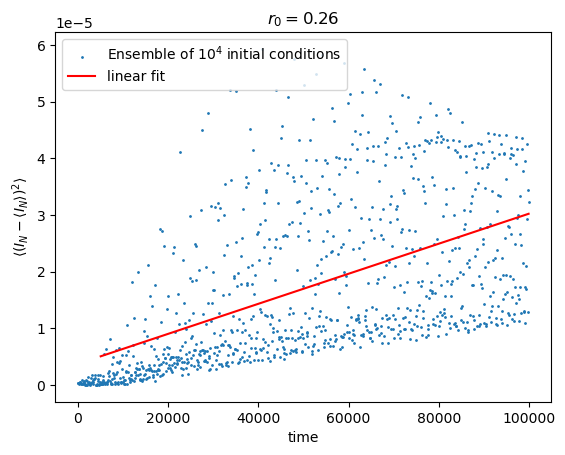

In [78]:
idx = 40

vx = time_samples.copy()
vy = I_std[idx, :]**2
# mask = np.logical_and(vx > 2500, vx < np.min([2e4, np.min(steps[idx])]))
# if np.count_nonzero(mask) < 10:
mask = vx < np.min(steps[idx])
vx = vx[mask]
vy = vy[mask]

plt.scatter(vx, vy, label='Ensemble of $10^4$ initial conditions', s=1)
plt.plot(actual_samples[idx], linear_resid(out_list[idx].params, actual_samples[idx]), label='linear fit', color='red')
plt.xlabel('time')
plt.ylabel('$\\langle(I_N - \\langle I_N\\rangle)^2\\rangle$')
plt.title(f"$r_0 = {r_list[idx]:.2f}$")
plt.legend()